# Project: Marketing strategy analysis

## Description
In this project I act as a marketing analyst that is investigating how well are the various Ad campaigns doing, and why is the business losing money.

## Data
- activity logs
- orders logs
- ad costs

In [1]:
import pandas as pd
import datetime as dt
from datetime import timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

### 1. Load and review data

In [2]:
try:
    visits = pd.read_csv('visits_info_short.csv')
    orders = pd.read_csv('orders_info_short.csv')
    costs = pd.read_csv('costs_info_short.csv')
except FileNotFoundError:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
#Change column naming to more "python" format
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
costs.columns = costs.columns.str.lower().str.replace(' ', '_')

#уSet proper date datatypes
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])

#Checking missing values - everything ok
#costs.info()
#visits.info()
#orders.info()

### 2. Functions for various metrics: LTV, ROI, retention rate, conversion rate

In [4]:
#Create functions that will allow me to quantify metrics for conversion, retention, LTV (lifetime value) and ROI (return on investment)
#The users will be split in groups based on their registration date. 
#cohort analysis
def get_profiles(visits, orders, ad_costs):

#aggregate out the first visit for each user
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # time of first activity is first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  
    )

    # extract date and month as a separate column for the first visit per user
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].dt.month

    # add True/False values is user ever ordered anything from the website
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # count unique users per ad channel and same date of first activity
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  
    )
    #adjust time format
    new_users['dt'] = pd.to_datetime(new_users['dt'])

    #join ad costs with users info to determine how many users each ad attracted
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['dt'] = pd.to_datetime(ad_costs['dt']).dt.date

    # compute acquisition_cost (CAC) as ad cost divided by unique users it brought
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # add acquisition costs into profiles
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(
        0
    )
    
    return profiles

#Compute retention rate
def get_retention(
    profiles,
    sessions, #logs of activity
    observation_date, 
    horizon_days, #how far into past the data will be considered relevant
    dimensions=[], #optional additional grouping dimensions
    ignore_horizon=False,
):

    # include info about paying users into dimensions
    dimensions = ['payer'] + dimensions

    # filter out users before set teimframe
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    #save filtered data into a new dataframe    
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # join filtered profiles with user sessions
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # function for grouping by desired parameters
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # data table with retention info per group
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # dynamis retention rates over time and per group
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # return the tables
    return result_raw, result_grouped, result_in_time

# function for conversion computations
def get_conversion(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
    ):

    if not ignore_horizon:
        cutoff_date = observation_date - timedelta(
            days=horizon_days - 1)
    else:
        cutoff_date = observation_date

    result_raw = profiles.query('dt <= @cutoff_date')

    # first purchase date
    first_orders = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # join first purchase with profiles
    result_raw = result_raw.merge(
        first_orders[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # compute lifetime - number of days between each purchase and first activity date
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # group by cohorts
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # function for grouping by defined parameters
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        #add running sum for unique users
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # divide paying user number at date by user number of users joined in the same cohort
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    #conversion table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions: 
        dimensions = []

    # dynamic conversion table (without cohort grouping)
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time
    

#function to compute lifetime value for each user
def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # filtering
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # orders info + profiles
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # compute each order lifetime
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # group bycohort if no other dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # 
    def group_by_dimensions(df, dims, horizon_days):
        # triangular pivot table for revenue
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # running sum of revenue
        result = result.fillna(0).cumsum(axis=1)

        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # join revenue with cohort sizes
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # compute LTV
        result = result.div(result['cohort_size'], axis=0)
        # exclude data with lifetime > timeframe of analysis
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes

        # create table for cac (customer acquisition cost)
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # compute average CAC
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # ROI = LTV / CAC
        roi = result.div(cac['cac'], axis=0)

        # get rid of infinite values in roi
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        roi['cohort_size'] = cohort_sizes
        #add cac to roi dataframe
        roi['cac'] = cac['cac']

        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # raw data
        result_grouped,  # LTV
        result_in_time,  # dynamic LTV
        roi_grouped,  #  ROI
        roi_in_time,  # dynamic ROI
    )

In [5]:
#Viz functions
def filter_data(df, window):
    # moving average in window range
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

def plot_retention(retention, retention_history, horizon):

    plt.figure(figsize=(15, 10))

    # drop cohort size and renetion on day 0
    retention = retention.drop(columns=['cohort_size', 0])

    # if indexing is by payer/non-payer only add indexing by cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # 2x2 plot
    ## 1-2 user retention (paying vs non-paying)
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of paying users')

    # note shared Y-axis with the first subplot
    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # dynamic payer retention
    ax3 = plt.subplot(2, 2, 3)
 
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    #
    retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon-1, aggfunc='mean'
    ).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition date')
    plt.title(
        'Dynamic retention of paying users after {} days'.format(
            horizon
        )
    )
    
    # dynamic non-payer retention
    ax4 = plt.subplot(2, 2, 4, sharey = ax3)
    retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    ).plot(grid=True, ax=ax4)
    plt.xlabel('Acquisition date')
    plt.title(
        'Dynamic retention of non-paying users after {} days'.format(
            horizon
        )
    )

    # prevent plot overlay
    plt.tight_layout()

    plt.show()



def plot_conversion(conversion, conversion_history, horizon, window=7):

    plt.figure(figsize=(15, 5))

    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('User conversion')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition date')
    plt.title('User conversion after {} days'.format(horizon))

    plt.tight_layout()
    plt.show()

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    cac_history = roi_history[['cac']]

    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')

    # dynamic ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition date')
    plt.title('LTV after {} days'.format(horizon))

    # dynamic cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition date')
    plt.title('Dynamic user acquisition cost')

    # roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Investment ground level')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')

    # dynamic roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Investment ground level')
    plt.xlabel('Acquisition date')
    plt.title('ROI after {} days'.format(horizon))

    plt.tight_layout()
    plt.show()

### 3. Data analysis

In [6]:
#Create user profiles
profiles = get_profiles(visits, orders, costs)
min_date = profiles['dt'].min()
max_date = profiles['dt'].max()
print(f'Min acquisition date: {min_date} \nMax acquisition date: {max_date}')
profiles.head()

Min acquisition date: 2019-05-01 
Max acquisition date: 2019-10-27


,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,5,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,7,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,10,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,8,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,10,False,0.230769


The dataset contains info staring May 2019 until October 2019 (almost complete).

In [7]:
#Analyze user contributions by country
profiles_by_country = (profiles.groupby('region')
                                .agg({'payer': ['sum', 'count']})
                                .rename(columns={'sum': 'total_payers', 'count': 'total_users'})
                                
)
profiles_by_country.columns = profiles_by_country.columns.droplevel(0)
profiles_by_country['payer_percent'] = profiles_by_country['total_payers'] / profiles_by_country['total_users'] * 100                              
profiles_by_country.sort_values(by='payer_percent', ascending=False)

,total_payers,total_users,payer_percent
region,,,
United States,6902,100002,6.901862
Germany,616,14981,4.111875
UK,700,17575,3.982930
France,663,17450,3.799427


 USA, Germany, Great Britain and France are app users. USA has the largest user pool and largest paying user fraction.

In [8]:
#Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. 
#Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
profiles_by_device = (profiles.groupby('device')
                                .agg({'payer': ['sum', 'count']})
                                .rename(columns={'sum': 'total_payers', 'count': 'total_users'})
                                
)
profiles_by_device.columns = profiles_by_device.columns.droplevel(0)
profiles_by_device['payer_percent'] = profiles_by_device['total_payers'] / profiles_by_device['total_users'] * 100                              
profiles_by_device.sort_values(by='payer_percent', ascending=False)


,total_payers,total_users,payer_percent
device,,,
Mac,1912,30042,6.364423
iPhone,3382,54479,6.207897
Android,2050,35032,5.851793
PC,1537,30455,5.046790


iPhone users are the majority and have 2nd largest fraction of paying users. The larges fraction of paying users are using app with Mac device

In [8]:
#Analyze ad channels
profiles_by_channel = (profiles.groupby('channel')
                                .agg({'payer': ['sum', 'count']})
                                .rename(columns={'sum': 'total_payers', 'count': 'total_users'})
                                
)
profiles_by_channel.columns = profiles_by_channel.columns.droplevel(0)
profiles_by_channel['payer_percent'] = profiles_by_channel['total_payers'] / profiles_by_channel['total_users']                               
profiles_by_channel.sort_values(by='payer_percent', ascending=False).style.format({'payer_percent':'{:.2%}'})

,total_payers,total_users,payer_percent
channel,,,
FaceBoom,3557,29144,12.20%
AdNonSense,440,3880,11.34%
lambdaMediaAds,225,2149,10.47%
TipTop,1878,19561,9.60%
RocketSuperAds,352,4448,7.91%
WahooNetBanner,453,8553,5.30%
YRabbit,165,4312,3.83%
MediaTornado,156,4364,3.57%
LeapBob,262,8553,3.06%


In [29]:
#more efficient code
(profiles
    .pivot_table(index='channel', values='payer', aggfunc=['count', 'sum', 'mean'])
    .reset_index()
    .rename(columns={'count': 'all_users', 'sum': 'paying_users', 'mean': 'payer_percent'})
    .droplevel(1, axis=1)
    .sort_values(by='payer_percent', ascending=False)
    .style.format({'payer_percent':'{:.2%}'})
    )

,channel,all_users,paying_users,payer_percent
1,FaceBoom,29144,3557,12.20%
0,AdNonSense,3880,440,11.34%
9,lambdaMediaAds,2149,225,10.47%
6,TipTop,19561,1878,9.60%
5,RocketSuperAds,4448,352,7.91%
7,WahooNetBanner,8553,453,5.30%
8,YRabbit,4312,165,3.83%
3,MediaTornado,4364,156,3.57%
2,LeapBob,8553,262,3.06%
4,OppleCreativeMedia,8605,233,2.71%


Organic users have the largest user pool but the lowers % of paying users. FaceBoom attracted the majority of paying users (3.5к) and exhibit the highest conversion. Notably, TipTop also attracted a large quantity of paying users. AdNonSense and lambdaMediaAds have high paying user fraction 10 - 11%, but low overall user pool.

### 4. Marketing analysis

In [15]:
#Compute how much money was spent on marketing campaigns
marketing_sum = costs['costs'].sum().round()
print('Total money spent on ads: ', marketing_sum)

#Evaluate which ad channels were invested the most in
costs_by_channel = (costs.groupby('channel')
                                .agg({'costs': 'sum'})
                                .rename(columns={'costs': 'total_ad_cost'})
                                                                
)
costs_by_channel['total_ad_cost'] = costs_by_channel['total_ad_cost'].astype('float').round(2)
costs_by_channel['marketing_percent'] = costs_by_channel['total_ad_cost'] / marketing_sum
costs_by_channel.sort_values(by='total_ad_cost', ascending=False).style.format({'marketing_percent':'{:.2%}'})

Total money spent on ads:  105497.0


,total_ad_cost,marketing_percent
channel,,
TipTop,54751.300000,51.90%
FaceBoom,32445.600000,30.75%
WahooNetBanner,5151.000000,4.88%
AdNonSense,3911.250000,3.71%
OppleCreativeMedia,2151.250000,2.04%
RocketSuperAds,1833.000000,1.74%
LeapBob,1797.600000,1.70%
lambdaMediaAds,1557.600000,1.48%
MediaTornado,954.480000,0.90%


TipTop and FaceBoom are the most expensive ad campaigns

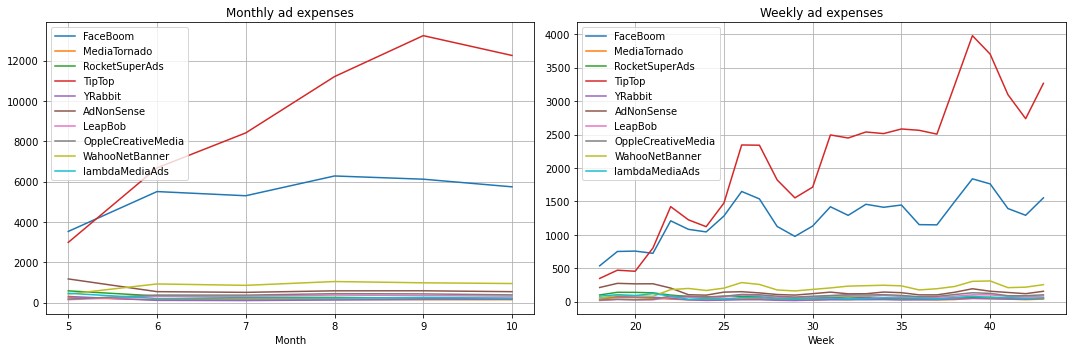

In [16]:
#Viz dynamic ad expenses

costs['month'] = costs['dt'].dt.month
costs['week'] = costs['dt'].dt.isocalendar().week

#list of all ad channels
channels = costs['channel'].unique()

plt.figure(figsize=(15, 5))

#
costs_monthly = costs.groupby(['channel', 'month']).agg({'costs': 'sum'})
ax1 = plt.subplot(1, 2, 1)
for channel in channels:
    data = costs_monthly.query('channel == @channel').droplevel(0)
    data.plot(grid=True, ax=ax1, label=channel)
plt.legend(channels)
plt.xlabel('Month')
plt.title('Monthly ad expenses')

costs_weekly = costs.groupby(['channel', 'week']).agg({'costs': 'sum'})
ax2 = plt.subplot(1, 2, 2)
for channel in channels:
    data = costs_weekly.query('channel == @channel').droplevel(0)
    data.plot(grid=True, ax=ax2)
plt.legend(channels)
plt.xlabel('Week')
plt.title('Weekly ad expenses')

plt.tight_layout()
plt.show()


In [17]:
#Compute average customer acquisition cost per ad channel
profiles.groupby('channel').agg({'acquisition_cost': 'mean'}).sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


### 5. Ad returns on investment

As a general rule here the ad is successful if customer acquisition cost was balanced out within 2 weeks. So we will define our observation timeframe as 14 days since the Nov 1st 2019 as the observation date.

In [18]:
#Let's look at LTV, CAC and ROI.
observation_date = dt.datetime(2019, 11, 1).date()
horizon_days = 14

#exclude organic users from analysis to focus on ad users
profiles_ad = profiles.query('channel != "organic"')

In [19]:
#using functions above compute all necessary metrics
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, 
    visits, 
    observation_date, 
    horizon_days, 
    dimensions=[], 
    ignore_horizon=False
    )

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
    )

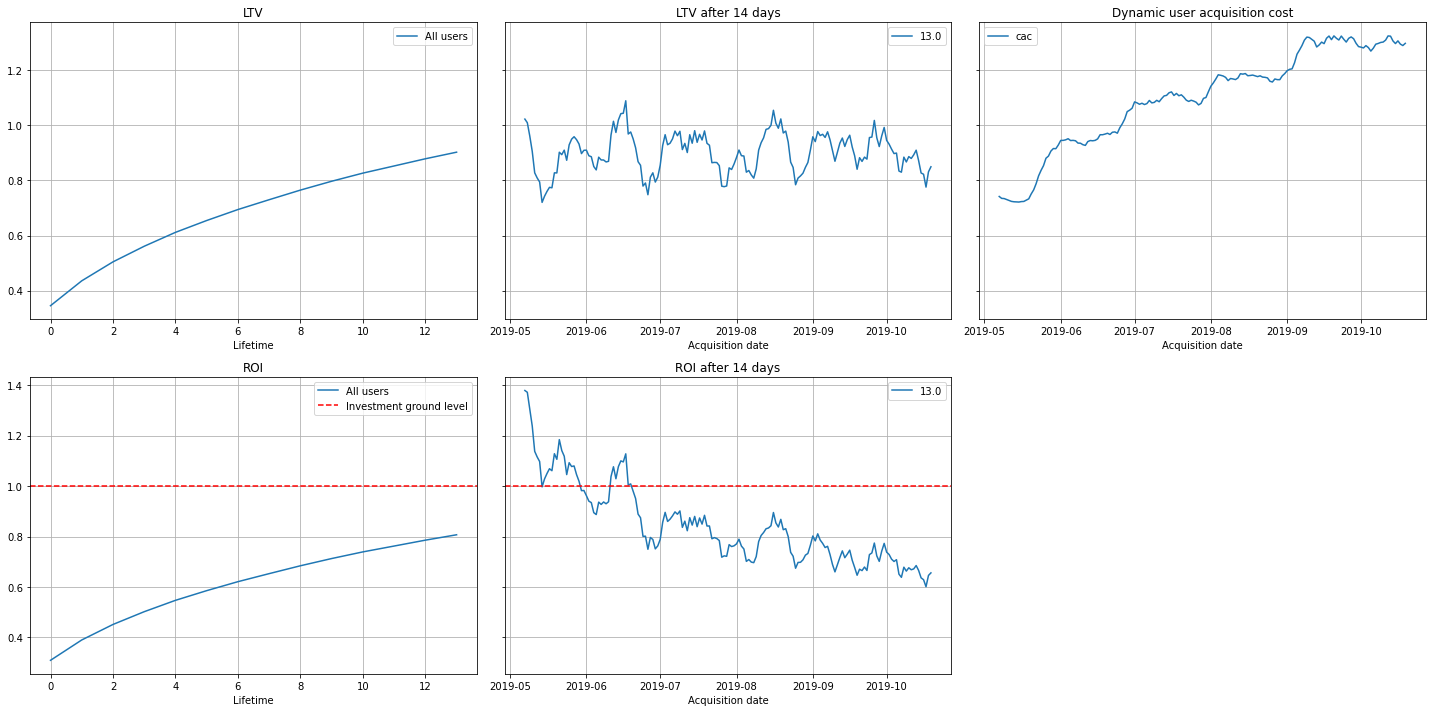

In [20]:
#LTV, CAC, ROI.

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_ad,  
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

 LTV is growing as expected. 

Acquisition cost spiked around mid May and continued increasing.

Generally, ads are not being covered by user payments over the 14 day period. Return on investment is actually decreasing which is a disaster.


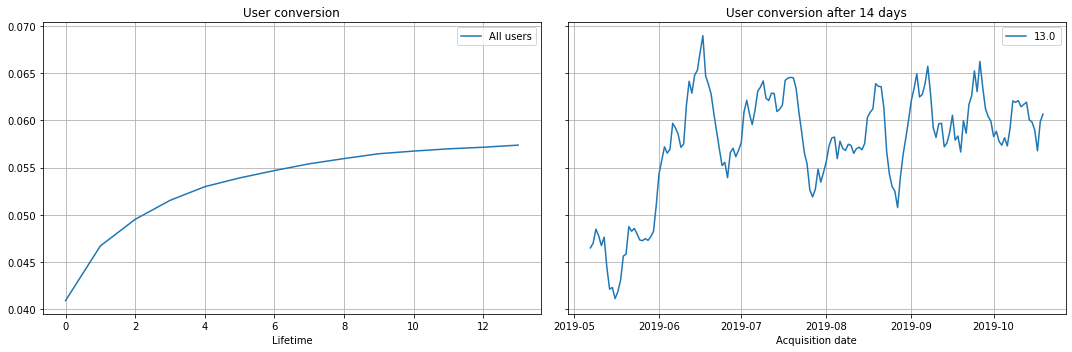

In [21]:
plot_conversion(conversion_grouped, conversion_history, 14) 

COnversion of users is clightly increasing with lifetime and is higher for newer users than for the older ones. Though it looks a bit unstable for different cohorts of users (based on their acquisition date)

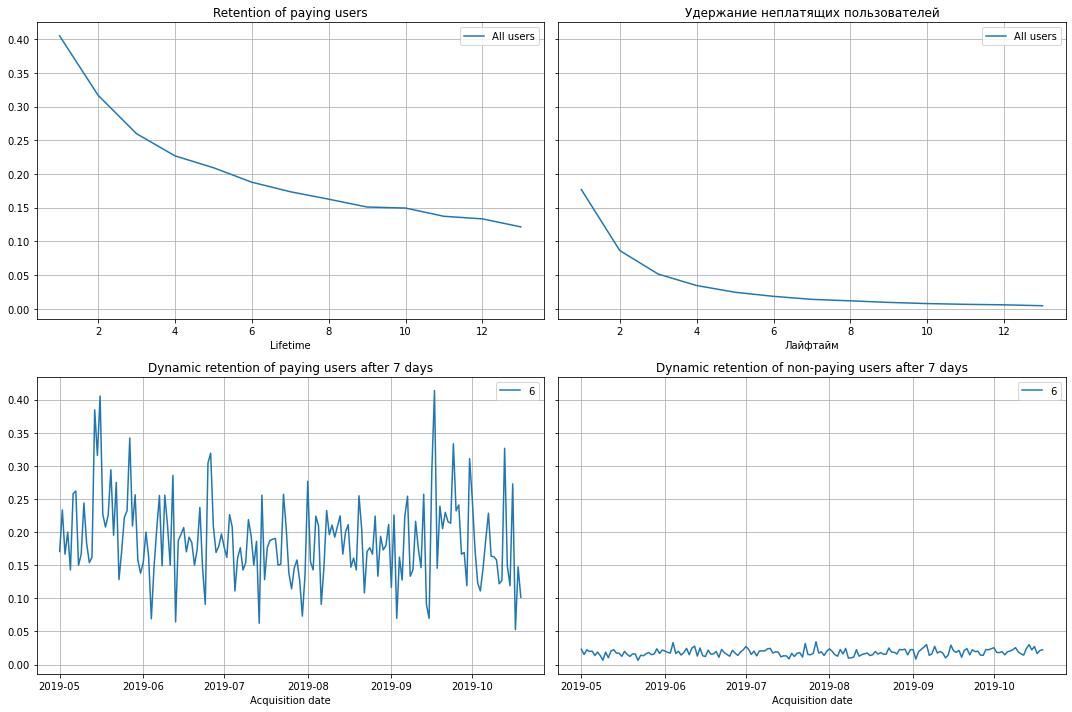

In [22]:
plot_retention(retention_grouped, retention_history, 7) 

Retention dynamics looks normal - it is decreasing over time and is much lower for non-paying users generally (2-3% vs 10-30%).


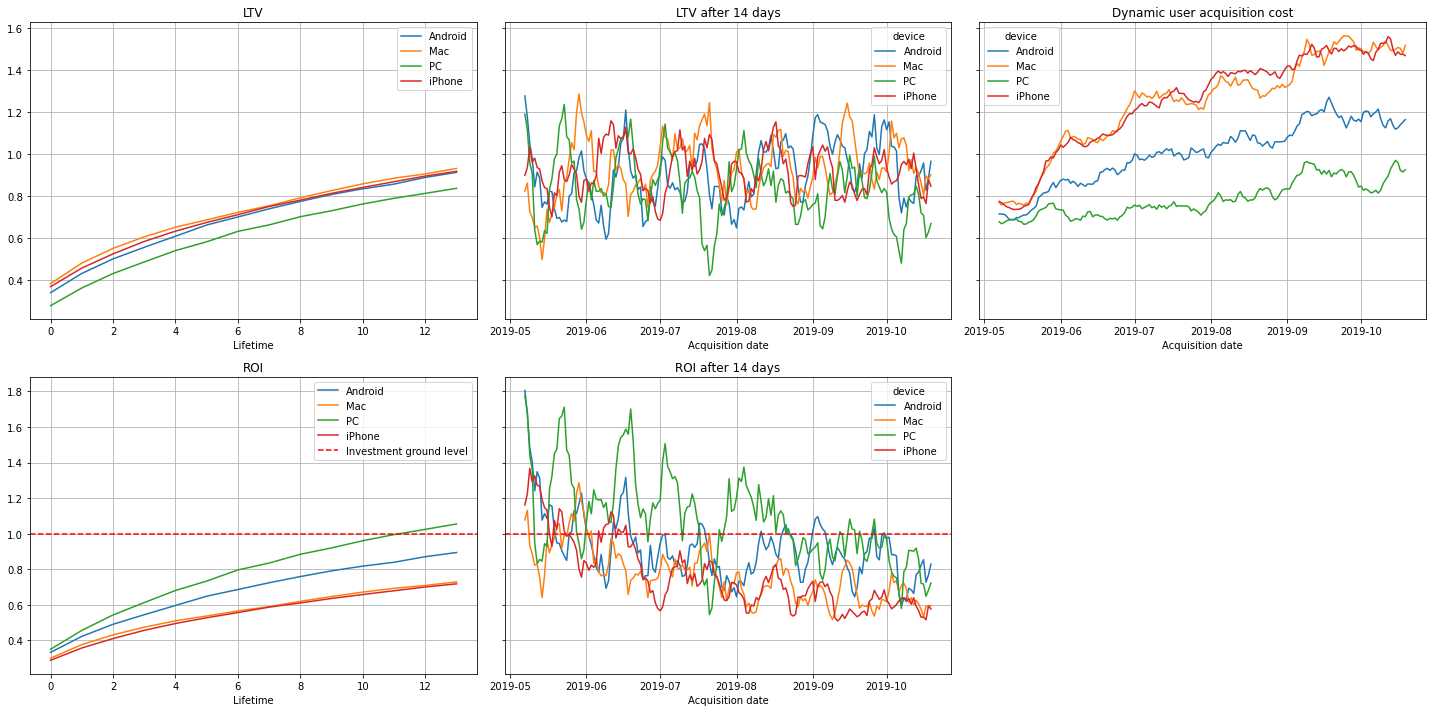

In [23]:
#Check differences base on user device
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_ad,  
    orders,
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False,
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

LTV is fairly similar for all devices, the smallest one is for PC users. Acquisition costs are increasing for all devices especially those with iPhone and Mac. Only PC users have positive ROI within 2 weeks, the others never reach the even point. 

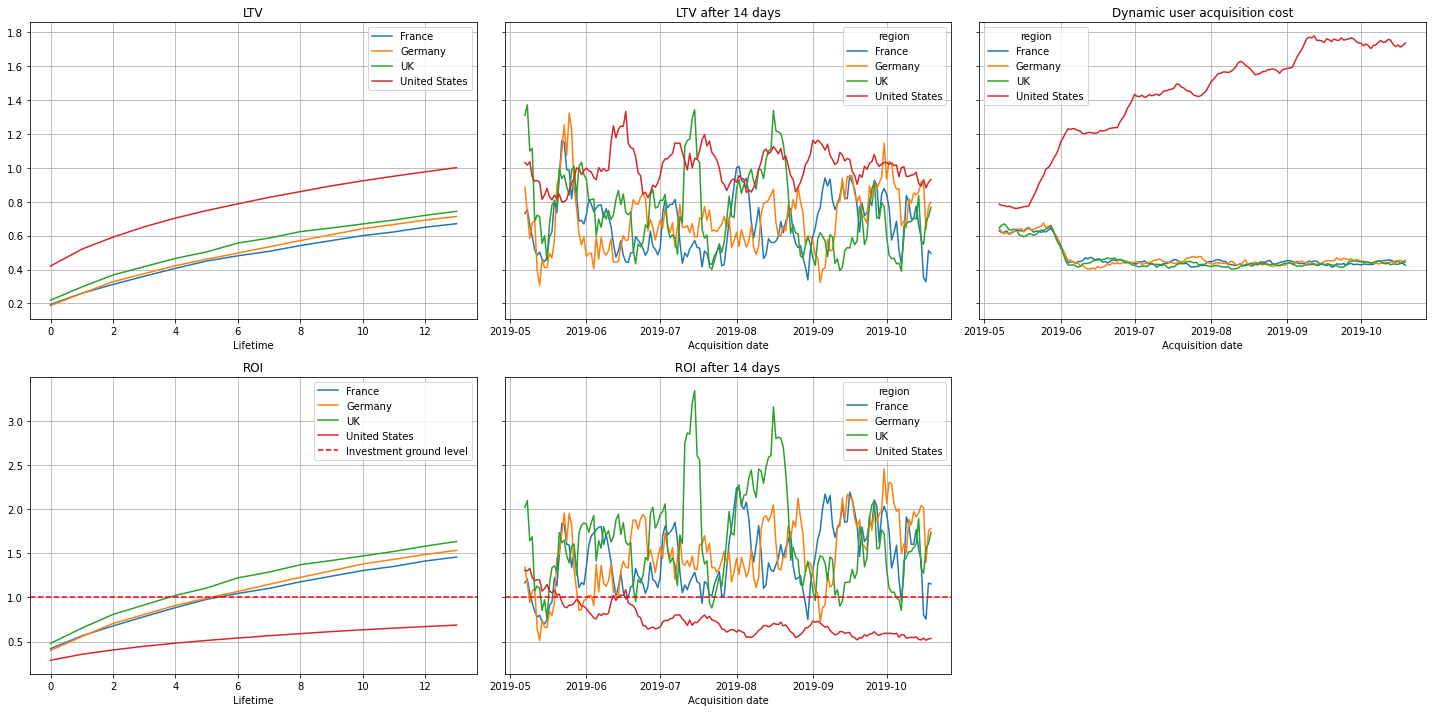

In [24]:
#analysis by country
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_ad,  
    orders,
    observation_date,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False,
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Only USA users have really low ROI that indicates that the acquisition cost of these users surpasses the value they'd bring to the app.

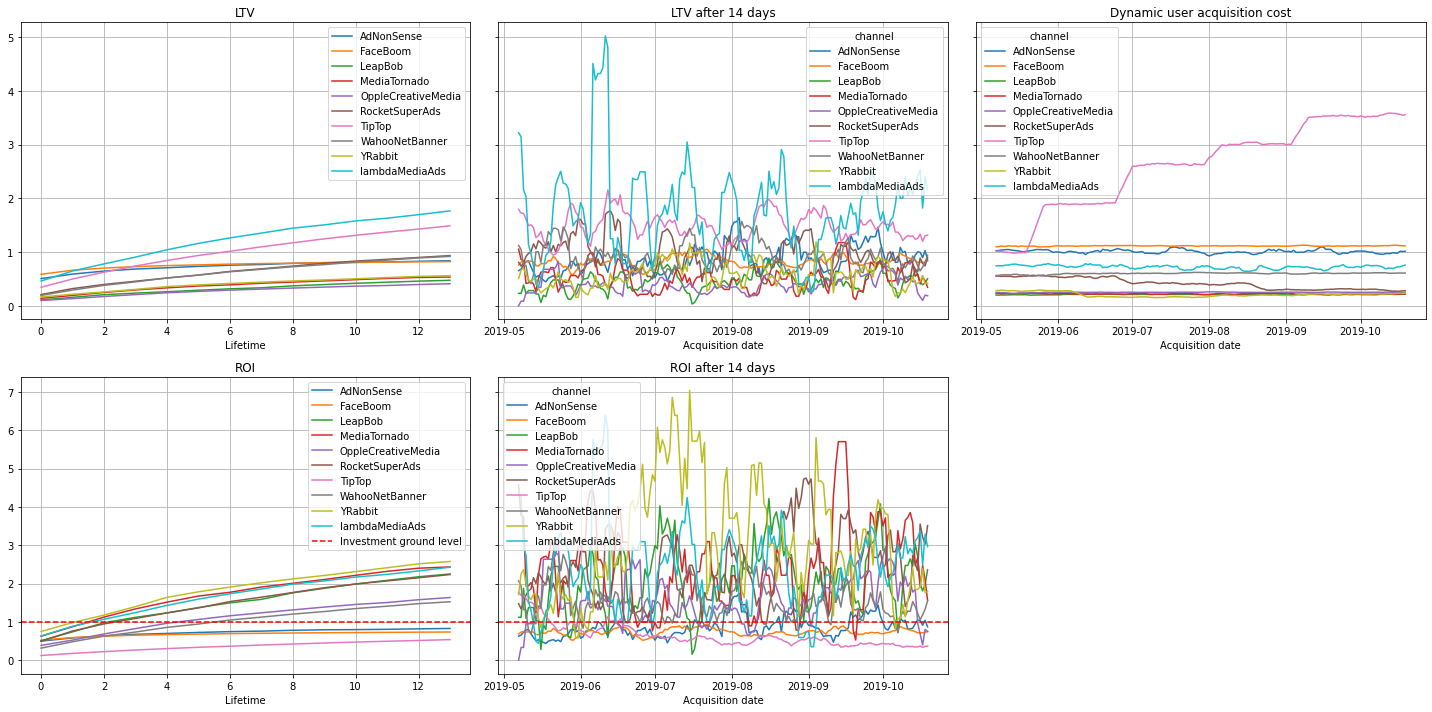

In [25]:
#ad channel analysis
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_ad,  
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

There are a few ad channels that are too expensive for the value they bring. Most prominent is TipTop, for which the user acquisition cost has been growing  since May. Additionally FaceBoom and AdNonSense - have expensive ads that don't pay off (as seen in ROI). 
The best ad channels are YRabbit, MediaTornado, lambdaMediaArts - for which users value is already sufficient on after 2 days since acquisition.

In [26]:
#Check which num of users per channel per country
profiles.groupby(['region', 'channel']).agg({'user_id' : 'count'})

user_id
region        channel                    
France        AdNonSense             1366
              LeapBob                2988
              OppleCreativeMedia     2991
              WahooNetBanner         2971
              lambdaMediaAds          742
              organic                6392
Germany       AdNonSense             1219
              LeapBob                2519
              OppleCreativeMedia     2562
              WahooNetBanner         2579
              lambdaMediaAds          649
              organic                5453
UK            AdNonSense             1295
              LeapBob                3046
              OppleCreativeMedia     3052
              WahooNetBanner         3003
              lambdaMediaAds          758
              organic                6421
United States FaceBoom              29144
              MediaTornado           4364
              RocketSuperAds         4448
              TipTop                19561
              YRabbit                4312
              organic               38173

count    1800.000000
mean       58.609611
std       107.740223
min         0.800000
25%         6.495000
50%        12.285000
75%        33.600000
max       630.000000
Name: costs, dtype: float64

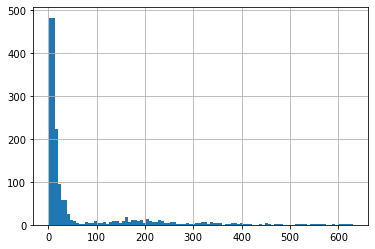

In [23]:
costs['costs'].hist(bins=100)
costs['costs'].describe()

TipTop exclusively attract customers from USA - this can exmplain why for both of these subgroups the acquisition cost dynamics is similar.

Conversion by ad channel


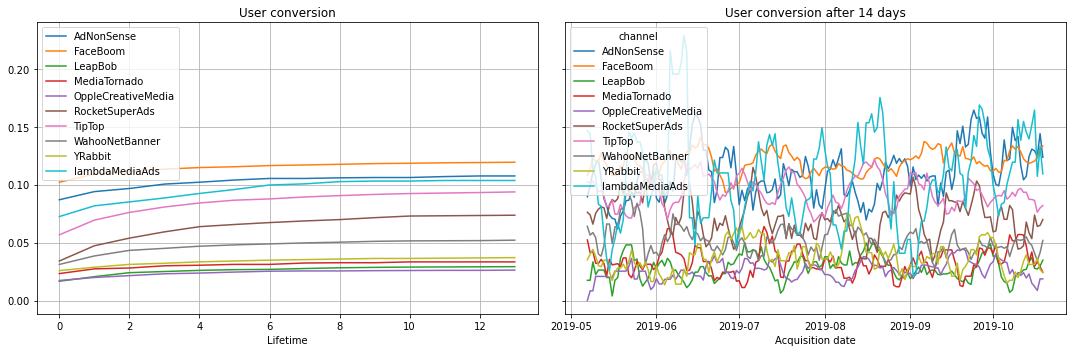

Retention by ad channel


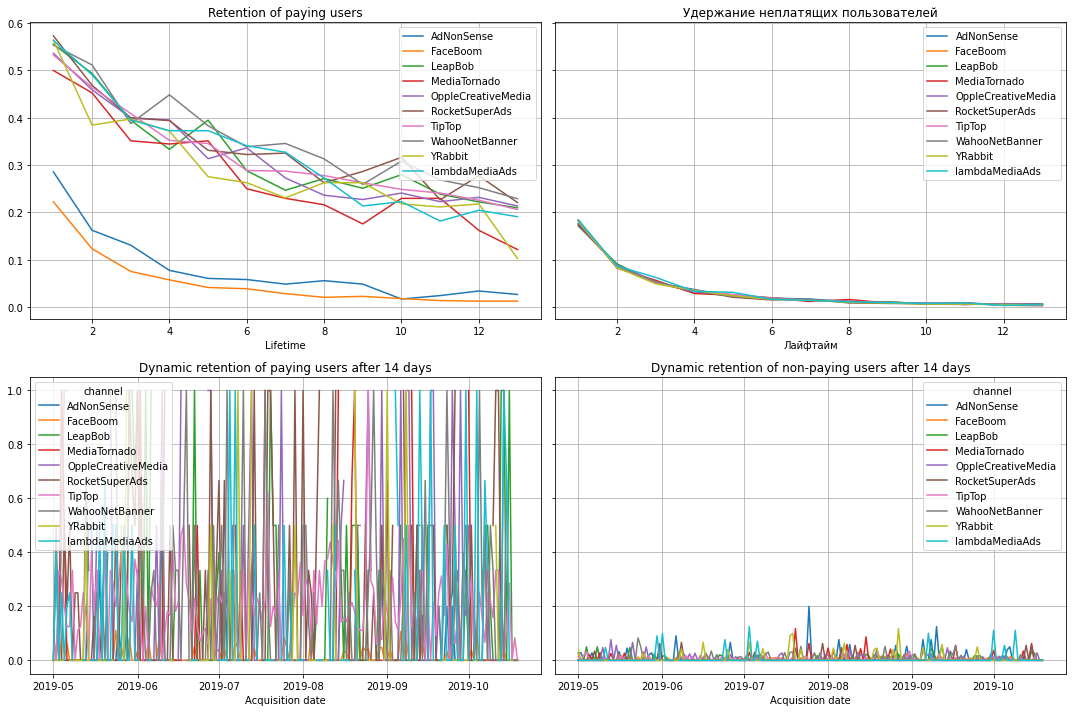

In [28]:
#analysis of conversion and retention by channel, country and device
print('Conversion by ad channel')
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_ad,
    visits,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
    )

plot_conversion(conversion_grouped, conversion_history, 14)

print('Retention by ad channel')
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_ad, 
    visits, 
    observation_date, 
    horizon_days, 
    dimensions=['channel'], 
    ignore_horizon=False
    )

plot_retention(retention_grouped, retention_history, 14)

FaceBoom and AdNonSense while having the highest conversion, have the lowest retention. For these two channels the portion of paying users after 1st day is already below 30% while for other channels it's 50%.
For TipTop the renetion is not bad on the other hand.

Conversion by device


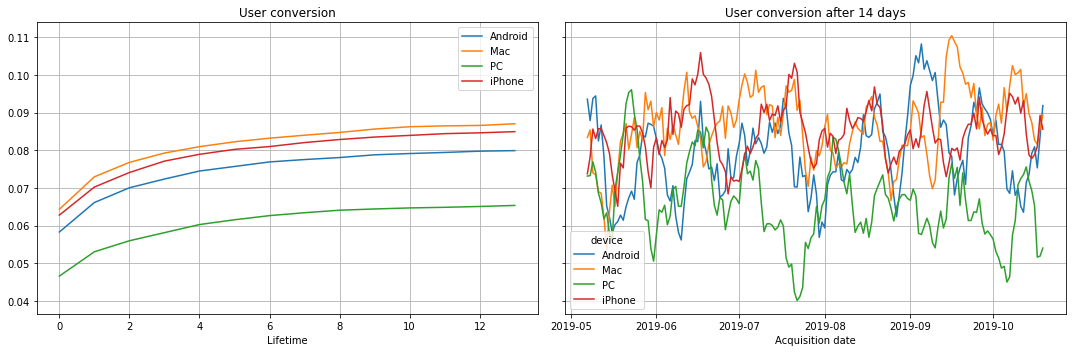

Retention by device


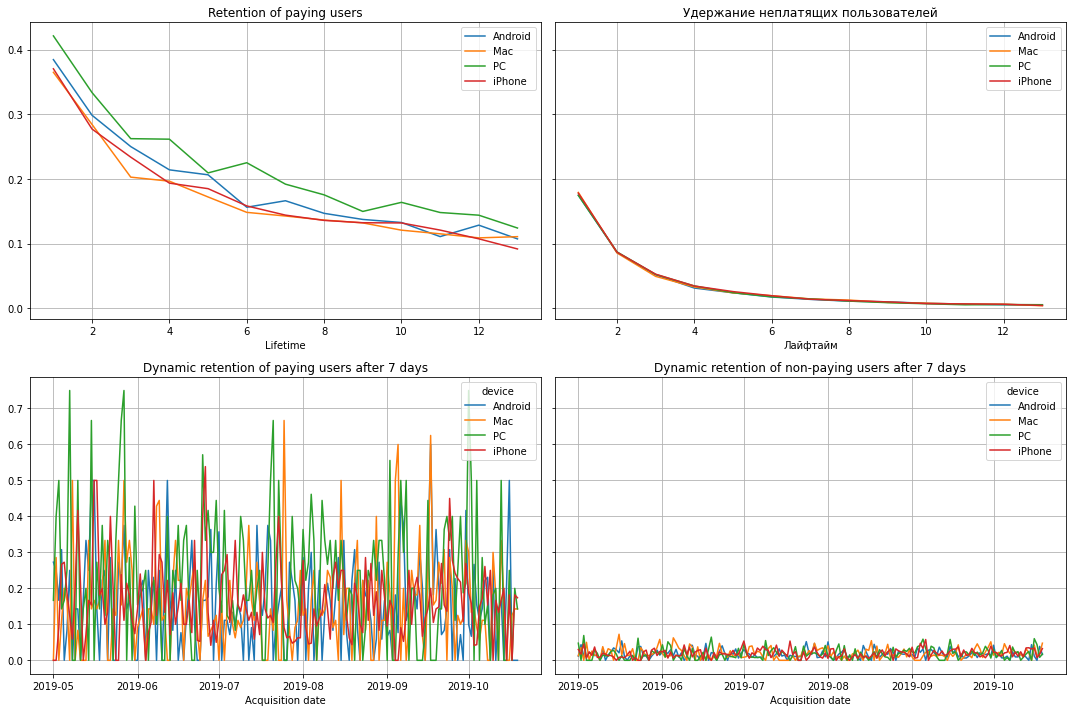

In [29]:
print('Conversion by device')
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_ad,
    visits,
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False,
    )

plot_conversion(conversion_grouped, conversion_history, 14)

print('Retention by device')
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_ad, 
    visits, 
    observation_date, 
    horizon_days, 
    dimensions=['device'], 
    ignore_horizon=False
    )

plot_retention(retention_grouped, retention_history, 7)

Mac and iPhone users have the highest conversion, and PC have the lowest. However PC users have slightly higher retention than others. 

Conversion by region


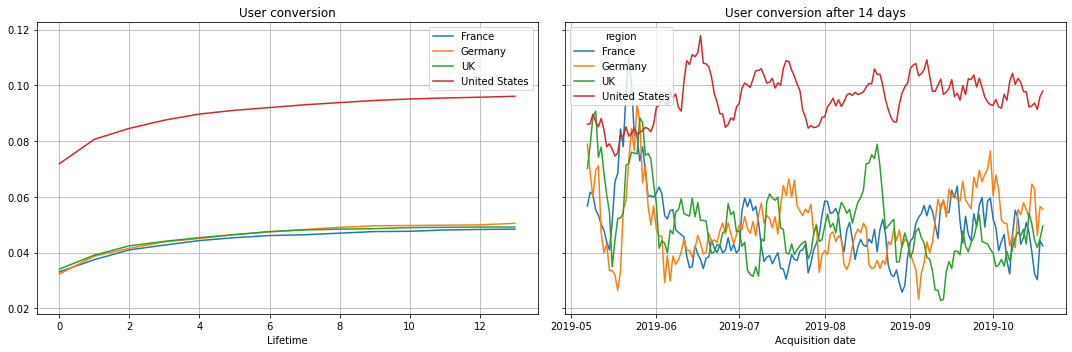

Retention by region


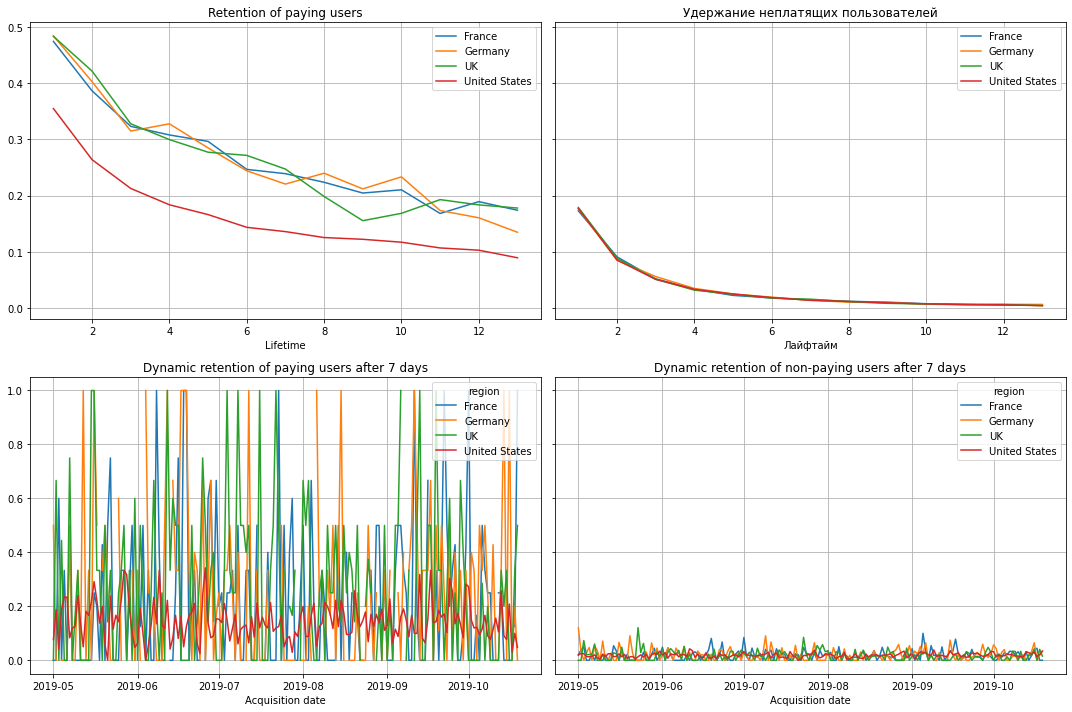

In [30]:
print('Conversion by region')
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_ad,
    visits,
    observation_date,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False,
    )

plot_conversion(conversion_grouped, conversion_history, 14)



print('Retention by region')
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_ad, 
    visits, 
    observation_date, 
    horizon_days, 
    dimensions=['region'], 
    ignore_horizon=False
    )

plot_retention(retention_grouped, retention_history, 7)

USA users while having the highest conversion - have also the lowest retention rate.

Let's consider ...
> **Are the ad campaigns overall efficient?**

No, they aren't. Currently ROI is below the even value so we are spending more money to acquire users than we gain from users.

> **Which devices, countries and ad channels should we focus on to address the issues?**

- THe worst user pool use Mac and iPhone due to low retention rate, and only PC users bring revenue since they have higher retention rate.  
- USA users are the only regional sub-group that has poor ROI due to again low retention. 
- As for the ad channels, TipTop, FaceBoom and AdNonSense are the ad campaigns that do not pay off for the ad costs they have. TipTop ads are way too expensive while FaceBoom and AdNonSense brings user pool with really low retention.

> **What is causing the company to lose money?**

High ad cost and low user retention are the causes. 

## 6. Conclusions
> **Causes of inefficient user acquisition strategy.**

The cost of user acquisition is high, and while many users are being attracted to the app, most of them do not spend enough money on the app or/and do not stay long enough to bring positive ROI. The main cause for that are poor investment decisions in the ad campaigns. 

> **Marketing recommendation.**

- Adjust ad pricing with TipTop first, then with FaceBoom and AdNonSense. If lower ad costs cannot be achieved, these ad campaigns should be dropped. 
- Additionally, we can aatempt to increase cost of the items that are being sold on the app to counter balance ad costs. However, this would be riski considering already direstate of user retention rates.

- Study organic users since they comprise the majority of the whole user pool but have very low conversion. Incorporate attractive deals, or ways to make sure these users stick around more.

- Invest more into more efficient ad companies such as LambdaMediaAds, RocketSuperAds, MediaTornado, YRabbit, LeapBob. They have the highest values for ROI and excellent retention rates. This indicated that they attract quality users.